 **Join Classifier of Type and Index Mutation on Lung Cancer DNA using Sequential Labeling Model**

---

Authors:
- Untari Novia Wisesty (1, 3)
- Ayu Purwarianti (1, 3)
- Adi Pancoro (2)
- Amrita Chattopadhyay (4)
- Nam Nhut Phan (5, 6, 7)
- Eric Y. Chuang (5, 7, 8)
- Tati Rajab Mengko (1)

Affiliation:
1. School of Electrical and Information Engineering, Bandung Institute of Technology, Bandung, Indonesia 
2. School of Life Sciences and Technology, Bandung Institute of Technology, Bandung, Indonesia
3. U-CoE AI-VLB
4. Department of Medical Research, Chine Medical University Hospital, Taichiung, Taiwan
5. Bioinformatics and Biostatistics Core, Centre of Genomic and Precision Medicine, National Taiwan University, Taipei 10055, Taiwan
6. Bioinformatics Program, Taiwan International Graduate Program, Institute of Information Science, Academia Sinica, Taipei, Taiwan
7. Graduate Institute of Biomedical Electronics and Bioinformatics, Department of Electrical Engineering, National Taiwan University, Taiwan
8. Master Program for Biomedical Engineering, China Medical University, Taichung 40402, Taiwan


---



- This source code is developed and run in Google Collaboratory, as well as data storage using Google Drive. Please make some modifications for the data path and some code according to the environment you are using.
- Prepare the required data using the data preprocessing module first before running the code below.

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Lib
import numpy as np
import pandas as pd
import pickle
import time
import keras
import keras.utils
import tensorflow as tf
from keras.layers import Embedding, Dense, Flatten, Dropout, SpatialDropout1D, TimeDistributed, LSTM, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras import Input, Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
path = '/content/drive/MyDrive/Paper SK2/'
datapath = path + 'Dataset/'
modelpath = path + 'Model/'
gene = 'EGFR'
# Hyperparameter
window_size = 150
stride = 50
testSchem = 'Uniform'
sampling = 'RUS' # '_' or 'RUS' (Random Undersampling)

# Check number of mutation

In [ ]:
window_size = 150
stride = 0
testSchem = 'Uniform'
sampling = '_' # '_' or 'RUS' (Random Undersampling)

data = np.load(datapath+gene+str(window_size)+sampling+str(stride)+testSchem+'.npz')
Y_train = data['Y_train']
Y_test = data['Y_test']
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()
print('Number of mutation in training set: ', Counter(Y_train))
print('Number of mutation in testing set: ', Counter(Y_test))

Jumlah mutasi training:  Counter({0.0: 11054357, 1.0: 3088, 3.0: 96, 2.0: 9})
Jumlah mutasi testing:  Counter({0.0: 1202796, 1.0: 344, 3.0: 10})


# Load Raw Data

In [ ]:
dfSeq = pd.read_csv(datapath+gene+'SeqData.csv')
dfMut = pd.read_csv(datapath+gene+'TargetSeqData.csv')
print(dfSeq)
print(dfMut)
dfSeq.head()

       Unnamed: 0  ...                                           Sequence
0               0  ...  ATGCGACCCTCCGCGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
1               1  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGACGCTGCTGG...
2               2  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
3               3  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
4               4  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
...           ...  ...                                                ...
18197       18197  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18198       18198  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18199       18199  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18200       18200  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18201       18201  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...

[18202 rows x 5 columns]
       Unnamed: 0  ...                                           Sequence
0           

,Unnamed: 0,Idx,Sample_ID,Gene_Name,Sequence
0,0,1,2717084,EGFR,ATGCGACCCTCCGCGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
1,1,2,2723457,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGACGCTGCTGG...
2,2,3,1765104,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
3,3,4,2723092,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
4,4,5,2195069,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...


# DNA Mapping Function

Integer Mapping for input sequence

In [ ]:
df = dfSeq['Sequence'].to_frame()
max_len = max(df.astype('str').applymap(lambda x: len(x)).max())
print('Data Dimension: ', len(df), max_len)

Dimensi data:  18202 3650


In [ ]:
InputData=np.zeros((len(df), max_len))
ii=0
for ii in range (0, len(df)):
  sekuens = df.iloc[ii][0]
  for jj in range (0,len(sekuens)-1):
    if sekuens[jj]=='T':
      InputData[ii][jj]=1
    elif sekuens[jj]=='C':
      InputData[ii][jj]=2
    elif sekuens[jj]=='A':
      InputData[ii][jj]=3
    elif sekuens[jj]=='G':
      InputData[ii][jj]=4
    else:
      InputData[ii][jj]=0

np.save(datapath+gene+'SeqInteger.npy', InputData)
print(InputData.shape)
print(np.unique(InputData))
InputData[0]

(18202, 3650)


array([3., 1., 4., ..., 0., 0., 0.])

Mapping Target Sequence

In [ ]:
df = dfMut['Sequence'].to_frame()
max_len = max(df.astype('str').applymap(lambda x: len(x)).max())
print('Data Dimension: ', len(df), max_len)

Dimensi data:  18202 3650


In [ ]:
# The target sequence is 1 if there is an SNV mutation, 2 insertions, 3 deletions, 4 delins, and 0 for normal
TargetData=np.zeros((len(df), max_len))
ii=0
for ii in range (0, len(df)):
  sekuens = df.iloc[ii][0]
  for jj in range (0,len(sekuens)-1):
    if (sekuens[jj]=='s'):  
      TargetData[ii][jj]=1
    elif (sekuens[jj]=='i'):
      TargetData[ii][jj]=2
    elif (sekuens[jj]=='d'):
      TargetData[ii][jj]=3
    elif (sekuens[jj]=='e'):
      TargetData[ii][jj]=4
    else:
      TargetData[ii][jj]=0

np.save(datapath+gene+'SeqTarget.npy', TargetData)
print(TargetData.shape)
print(np.unique(TargetData))
TargetData[0]

(18202, 3650)


array([0., 0., 0., ..., 0., 0., 0.])

# Data Preparation

## Reshape sequence into sub sequence with shorter length

In [ ]:
# load the required data:
data = np.load(datapath+gene+'SeqInteger.npy')
target = np.load(datapath+gene+'SeqTarget.npy')
dfType = pd.read_csv(datapath+gene+'DataDivision.csv')

# Division of training and testing data based on the file 'LungDataDivision.csv'
cek = dfType[dfType['Dataset']==0] # data train
id = np.array(cek['Idx'])
inputTrain = data[id-1]
targetTrain = target[id-1]
print('Data train:')
print(inputTrain.shape)
print(targetTrain.shape)

cek = dfType[dfType['Dataset']==1] # data testing
id = np.array(cek['Idx'])
inputTest = data[id-1]
targetTest = target[id-1]
print('Data test:')
print(inputTest.shape)
print(targetTest.shape)

Data train:
(16386, 3650)
(16386, 3650)
Data test:
(1816, 3650)
(1816, 3650)


### Without overlap 

In [ ]:
# Train data:
inputTrain = inputTrain.flatten()
targetTrain = targetTrain.flatten()
# Test data:
inputTest = inputTest.flatten()
targetTest = targetTest.flatten()

# Checks whether the length of the sequence to be reshaped matches the window_size
n = len(inputTrain)
mod = n % window_size
if mod != 0:
  pad = np.zeros((window_size-mod))
  inputTrain = np.hstack((inputTrain, pad))
  targetTrain = np.hstack((targetTrain, pad))
n = len(inputTest)
mod = n % window_size
if mod != 0:
  pad = np.zeros((window_size-mod))
  inputTest = np.hstack((inputTest, pad))
  targetTest = np.hstack((targetTest, pad))

# Reshape data according to window_size
X_train = np.reshape(inputTrain, (-1,window_size))
Y_train = np.reshape(targetTrain, (-1,window_size))
X_test = np.reshape(inputTest, (-1,window_size))
Y_test = np.reshape(targetTest, (-1,window_size))

# Remove empty sub sequence
cek = np.all(X_train == np.zeros(window_size), axis=1)
X_train = X_train[cek==False]
Y_train = Y_train[cek==False]

cek = np.all(X_test == np.zeros(window_size), axis=1)
X_test = X_test[cek==False]
Y_test = Y_test[cek==False]

# Save data
np.savez(datapath+gene+str(window_size)+'_'+'0'+testSchem+'.npz', X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
print(X_train.shape)
print(X_test.shape)

(1129595, 50)
(125304, 50)


### With Sliding Window

In [ ]:
# Train data:
inputTr = inputTrain.flatten()
targetTr = targetTrain.flatten()
# Test data:
inputTs = inputTest.flatten()
targetTs = targetTest.flatten()

# Reshape data according to window size and stride
shape = (inputTr.shape[0] - window_size + 1, window_size) + inputTr.shape[1:]
strides = (inputTr.strides[0],) + inputTr.strides
X_train = np.lib.stride_tricks.as_strided(inputTr, shape=shape, strides=strides)[::stride,:]
Y_train = np.lib.stride_tricks.as_strided(targetTr, shape=shape, strides=strides)[::stride,:]
shape = (inputTs.shape[0] - window_size + 1, window_size) + inputTs.shape[1:]
strides = (inputTs.strides[0],) + inputTs.strides
X_test = np.lib.stride_tricks.as_strided(inputTs, shape=shape, strides=strides)[::stride,:]
Y_test = np.lib.stride_tricks.as_strided(targetTs, shape=shape, strides=strides)[::stride,:]

# Remove empty sub sequence
cek = np.all(X_train == np.zeros(window_size), axis=1)
X_train = X_train[cek==False]
Y_train = Y_train[cek==False]

cek = np.all(X_test == np.zeros(window_size), axis=1)
X_test = X_test[cek==False]
Y_test = Y_test[cek==False]

np.savez(datapath+gene+str(window_size)+'_'+str(stride)+testSchem+'.npz', X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
print(X_train.shape)
print(X_test.shape)

(1140631, 100)
(126525, 100)


## Undersampling

In [ ]:
# Load data train
data = np.load(datapath+gene+str(window_size)+'_'+str(stride)+testSchem+'.npz')
X_train = data['X_train']
Y_train = data['Y_train']
X_test = data['X_test']
Y_test = data['Y_test']

In [ ]:
# Create temporary sub sequence of target data (if there is a mutation then it is annotated 1)
Y = np.zeros(len(Y_train))
for ii in range(len(Y_train)):
  if ((np.max(Y_train[ii]))!=0):
    Y[ii] = 1
print('Number of sub sequences before resampling: ', Counter(Y))
# Indexing the data before resampling
counter = range(0,len(Y))
counter = (np.array(counter)).reshape(-1, 1)
# Resampling process
rus = RandomUnderSampler(random_state=0)
index, Y_resampled = rus.fit_resample(counter,Y)
index = index.reshape(1, -1)
print('Number of sub sequences after resampling: ', Counter(Y_resampled))

# Save resampled data
X_train = X_train[index]
Y_train = Y_train[index]
X_train = X_train[0]
Y_train = Y_train[0]
np.savez(datapath+gene+str(window_size)+'RUS'+str(stride)+testSchem+'.npz', X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
print(X_train.shape)
print(Y_train.shape)

Jumlah baris data sebelum resampling:  Counter({0.0: 1190969, 1.0: 202304})
Jumlah baris data setelah resampling:  Counter({0.0: 202304, 1.0: 202304})
(404608, 150)
(404608, 150)


# Generate index cross validation

In [ ]:
# Load data train
data = np.load(datapath+gene+str(window_size)+sampling+str(stride)+testSchem+'.npz')
X_train = data['X_train']
# Generate index cross validation
kf = KFold(n_splits=5, shuffle=True)
trainIdx = []
valIdx = []
for train, val in kf.split(X_train):
  trainIdx.append(train)
  valIdx.append(val)
  print(len(train),len(val))
  
# Save data
open_file = open(modelpath+gene+'CV'+str(window_size)+sampling+str(stride)+testSchem+'.pkl', "wb")
pickle.dump([trainIdx,valIdx], open_file)
open_file.close()

83550 20888
83550 20888
83550 20888
83551 20887
83551 20887


# Embedding Matrix

## Voss representation

In [ ]:
# Nucleotide order: T, C, A, G
embedding_matrix = np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
mapping = 'Voss'

# Convolutional Neural Network

In [ ]:
dnn = 'CNN'
numlayer = 4
dropout = 0
layer = str(numlayer)

def modelDNN():
  model = Sequential()
  # Embedding layer for DNA mapping
  model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                          input_length = window_size, trainable=False))
  # Conv1D layer
  model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu', strides=1))
  if dropout>0:
    model.add(Dropout(dropout))
  model.add(Conv1D(256, kernel_size=5, padding='same', activation='relu', strides=1))
  if dropout>0:
    model.add(Dropout(dropout))
  if numlayer == 4:
    model.add(Conv1D(256, kernel_size=5, padding='same', activation='relu', strides=1))
    if dropout>0:
      model.add(Dropout(dropout))
    model.add(Conv1D(256, kernel_size=5, padding='same', activation='relu', strides=1))
    if dropout>0:
      model.add(Dropout(dropout))
  # Dense layer
  model.add(TimeDistributed(Dense(numClasses, activation="softmax")))
  
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  return model

# Recurrent Neural Network

## BiLSTM

In [ ]:
dnn = 'BiLSTM'
numlayer = 2
units = 256 #unit LSTM
dropout = 0.2
layer = str(numlayer)+'_'+str(units)

def modelDNN():
  # Architecture:
  input = Input(shape=(window_size,)) # Input layer
  model = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                          input_length = window_size, trainable=False)(input)
  model = Bidirectional(LSTM(units, return_sequences=True))(model)
  if dropout>0:
    model = Dropout(dropout)(model)
  if numlayer==2:
    model = Bidirectional(LSTM(units, return_sequences=True))(model)
    if dropout>0:
      model = Dropout(dropout)(model)
  out = TimeDistributed(Dense(numClasses, activation="softmax"))(model)  # TimeDistributed wrapper layer, return sequences. Fully connected layer. 
  model = Model(input, out)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  return model

## GRU

In [ ]:
dnn = 'GRU'
numlayer = 1
units = 128 #unit LSTM
dropout = 0.2
layer = str(numlayer)+'_'+str(units)

def modelDNN():
  # Architecture:
  input = Input(shape=(window_size,)) # Input layer
  model = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                          input_length = window_size, trainable=False)(input)
  model = Bidirectional(GRU(units, return_sequences=True))(model)
  if dropout>0:
    model = Dropout(dropout)(model)
  if numlayer==2:
    model = Bidirectional(GRU(units, return_sequences=True))(model)
    if dropout>0:
      model = Dropout(dropout)(model)
  out = TimeDistributed(Dense(numClasses, activation="softmax"))(model)  # TimeDistributed wrapper layer, return sequences. Fully connected layer. 
  model = Model(input, out)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  return model

# Training DNN

## Train and Validate using k-fold CV

In [ ]:
# Load training data
data = np.load(datapath+gene+str(window_size)+sampling+str(stride)+testSchem+'.npz')
X = data['X_train']
Y = data['Y_train']
numClasses = len(np.unique(Y))

# Load index cross validation
open_file = open(modelpath+gene+'CV'+str(window_size)+sampling+str(stride)+testSchem+'.pkl', "rb")
cvIdx = pickle.load(open_file)
open_file.close()

print('Number of class: ', numClasses)

# hyper parameters
embedding_dim = embedding_matrix.shape[1]
vocab_size = 4+1 # number of nucleotide = 4

Jumlah kelas:  5


In [ ]:
# Train all fold in 5-fold CV
print('Window size: ', window_size)
print('Stride: ', stride)
print('Sampling: ', sampling)
if (dnn == 'BiLSTM'): print('BiLSTM: ', layer, dropout)
else: print('CNN: ', layer, dropout)

EPOCHS = 100
BATCH_SIZE = 48

valLoss = 100 #Initiation valLoss

for ii in range(0,5): # Iteration for Cross Validation
  print(ii)
  X_train, X_val = X[(cvIdx[0][ii])], X[(cvIdx[1][ii])]
  Y_train, Y_val = Y[(cvIdx[0][ii])], Y[(cvIdx[1][ii])]
  
  # Converts the target training and validation data representation to one hot encoding
  Y_train = [tf.keras.utils.to_categorical(i, num_classes=numClasses) for i in Y_train]
  Y_train = np.array(Y_train)
  Y_val = [tf.keras.utils.to_categorical(i, num_classes=numClasses) for i in Y_val]
  Y_val = np.array(Y_val)
  
  # Create model
  model = modelDNN()
  # Train model
  train_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)
  # Save the best model according to val_loss
  if (train_history.history['val_loss'][EPOCHS-1]<valLoss):
    valLoss = train_history.history['val_loss'][EPOCHS-1]
    trainLoss = train_history.history['loss'][EPOCHS-1]
    model.save(modelpath+cancer+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+'_'+str(stride)+'.h5')
    np.savez(modelpath+cancer+'Loss2.npz',
             trainLoss=train_history.history['loss'], valLoss=train_history.history['val_loss'])

print('Train Loss: ', trainLoss)
print('Validation Loss: ', valLoss)

In [ ]:
# If you have limited source, use this code to train the model,
# fold by fold (manually) in 5-fold CV, and select the best model manually
fold = 0
X_train, X_val = X[(cvIdx[0][fold])], X[(cvIdx[1][fold])]
Y_train, Y_val1 = Y[(cvIdx[0][fold])], Y[(cvIdx[1][fold])]
  
# Converts the target training and validation data representation to one hot encoding
Y_train = [tf.keras.utils.to_categorical(i, num_classes=numClasses) for i in Y_train]
Y_train = np.array(Y_train)
Y_val = [tf.keras.utils.to_categorical(i, num_classes=numClasses) for i in Y_val1]
Y_val = np.array(Y_val)

print('Window size: ', window_size)
print('Stride: ', stride)
print('Sampling: ', sampling)
if (dnn == 'BiLSTM'): print('BiLSTM: ', layer, dropout)
elif (dnn == 'GRU'): print('GRU: ', layer, dropout)
else: print('CNN: ', layer, dropout)

EPOCHS = 20
BATCH_SIZE = 48
itr1 = 0
itr2 = 5
for ii in range(itr1,itr2):
  print(ii)
  # Create model
  if ii == 0:
    model = modelDNN()
    trainLoss = []
    valLoss = []
  else:
    model = tf.keras.models.load_model(modelpath+gene+str(fold)+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.h5')
    loss1 = np.load(modelpath+'Loss'+gene+str(fold)+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.npz')
    trainLoss = loss1['trainLoss']
    valLoss = loss1['valLoss']
  
  # Train model
  train_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                          epochs=EPOCHS, batch_size=BATCH_SIZE)
  model.save(modelpath+gene+str(fold)+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.h5')
  trainLoss = np.append(trainLoss, train_history.history['loss'])
  valLoss = np.append(valLoss, train_history.history['val_loss'])
  np.savez(modelpath+'Loss'+gene+str(fold)+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.npz', trainLoss=trainLoss, valLoss=valLoss)

print('Train Loss: ', train_history.history['loss'][EPOCHS-1])
print('Validation Loss: ', train_history.history['val_loss'][EPOCHS-1])

# Evaluation on validation data
pred = np.argmax(model.predict(X_val), axis=-1)
pred = pred.flatten()
Y_val1 = Y_val1.flatten()
target_names = ['Normal', 'SNV', 'Insertion', 'Deletion', 'Delins']
print(classification_report(Y_val1, pred, digits=4, target_names=target_names, zero_division=0))
print(gene)

# Plot train and validation loss
plt.plot(trainLoss)
plt.plot(valLoss)
plt.title('')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Plot train and validation loss

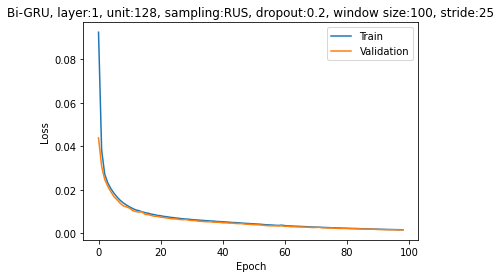

In [ ]:
# Hyperparameters:
window_size = 100
stride = 25
sampling = 'RUS' # '_' atau 'RUS' (Random Undersampling)
dnn = 'GRU'
numlayer = 1
dropout = 0.2
units = 128 #unit LSTM
layer1 = str(numlayer)
layer = str(numlayer)+'_'+str(units)

loss1 = np.load(modelpath+'Loss'+gene+str(fold)+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.npz')
trainLoss = loss1['trainLoss']
valLoss = loss1['valLoss']
# Plot train and validation loss
plt.plot(trainLoss[0:99])
plt.plot(valLoss[0:99])
plt.title('Bi-GRU, layer:'+layer1+', unit:'+str(units)+ ', sampling:'+sampling+', dropout:'+str(dropout)+', window size:'+str(window_size)+', stride:'+str(stride))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Train using holdout validation

In [ ]:
# Load data training dan testing
data = np.load(datapath+gene+str(window_size)+sampling+str(stride)+testSchem+'.npz')
X_train = data['X_train']
Y_train = data['Y_train']
numClasses = len(np.unique(Y_train))

# Converts the target training data representation to one hot encoding
Y_train = [tf.keras.utils.to_categorical(i, num_classes=numClasses) for i in Y_train]
Y_train = np.array(Y_train)

embedding_dim = embedding_matrix.shape[1]
vocab_size = 4+1 # number of nucleotide = 4

print(gene, numClasses)

SMARCA4 4


Window size:  150
Stride:  50
Sampling:  RUS
GRU:  2_256 0.2
SMARCA4
4
Epoch 1/20
2310/2310 [==============================] - 104s 42ms/step - loss: 5.2946e-05 - accuracy: 1.0000 - val_loss: 6.7725e-04 - val_accuracy: 0.9999
Epoch 2/20
2310/2310 [==============================] - 96s 41ms/step - loss: 4.7653e-05 - accuracy: 1.0000 - val_loss: 6.4210e-04 - val_accuracy: 0.9999
Epoch 3/20
2310/2310 [==============================] - 96s 41ms/step - loss: 5.2890e-05 - accuracy: 1.0000 - val_loss: 7.7201e-04 - val_accuracy: 0.9999
Epoch 4/20
2310/2310 [==============================] - 96s 41ms/step - loss: 5.6121e-05 - accuracy: 1.0000 - val_loss: 7.6444e-04 - val_accuracy: 0.9999
Epoch 5/20
2310/2310 [==============================] - 96s 41ms/step - loss: 5.4890e-05 - accuracy: 1.0000 - val_loss: 6.0931e-04 - val_accuracy: 0.9999
Epoch 6/20
2310/2310 [==============================] - 96s 41ms/step - loss: 5.3535e-05 - accuracy: 1.0000 - val_loss: 5.8023e-04 - val_accuracy: 0.9999
Epoc

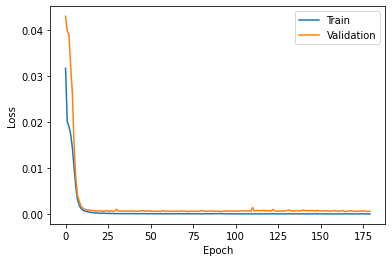

In [ ]:
print('Window size: ', window_size)
print('Stride: ', stride)
print('Sampling: ', sampling)
if (dnn == 'BiLSTM'): print('BiLSTM: ', layer, dropout)
elif (dnn == 'GRU'): print('GRU: ', layer, dropout)
else: print('CNN: ', layer, dropout)
print(gene)

EPOCHS = 20
BATCH_SIZE = 12
itr1 = 0
itr2 = 5
for ii in range(itr1,itr2):
  print(ii)
  # Create model
  if ii == 0:
    model = modelDNN()
    trainLoss = []
    valLoss = []
  else:
    model = tf.keras.models.load_model(modelpath+gene+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.h5')
    loss1 = np.load(modelpath+'Loss'+gene+dnn+layer+sampling+str(dropout)+mapping+str(window_size)str(stride)+'.npz')
    trainLoss = loss1['trainLoss']
    valLoss = loss1['valLoss']
  
  # Train model
  train_history = model.fit(X_train, Y_train, validation_split=0.1, shuffle=True,
                          epochs=EPOCHS, batch_size=BATCH_SIZE)
  model.save(modelpath+gene+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.h5')
  trainLoss = np.append(trainLoss, train_history.history['loss'])
  valLoss = np.append(valLoss, train_history.history['val_loss'])
  np.savez(modelpath+'Loss'+gene+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.npz', trainLoss=trainLoss, valLoss=valLoss)

print('Train Loss: ', train_history.history['loss'][EPOCHS-1])
print('Validation Loss: ', train_history.history['val_loss'][EPOCHS-1])

# Plot train and validation loss
plt.plot(trainLoss)
plt.plot(valLoss)
plt.title('')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Model Visualization

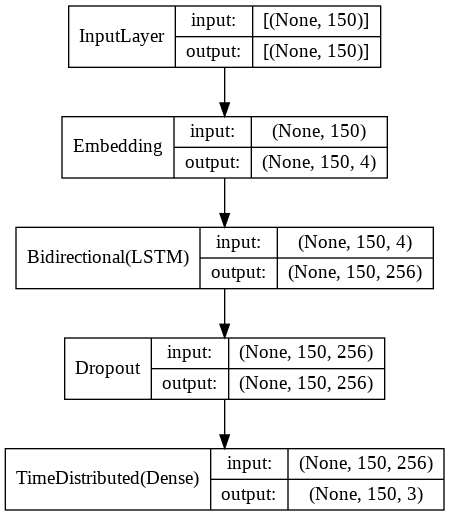

In [ ]:
model = tf.keras.models.load_model(modelpath+gene+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.h5')
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=True, dpi=96
)

# Testing DNN

### Exact match

Window size:  150
Stride:  50
Sampling:  RUS
BiLSTM:  256 0.2
PTPRT
              precision    recall  f1-score   support

      Normal     1.0000    1.0000    1.0000   1202796
         SNV     0.9905    0.9070    0.9469       344
    Deletion     0.8000    0.8000    0.8000        10

    accuracy                         1.0000   1203150
   macro avg     0.9301    0.9023    0.9156   1203150
weighted avg     1.0000    1.0000    1.0000   1203150

Runtime:  6.16771936416626


[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'SNV'), Text(0, 2.5, 'Deletion')]

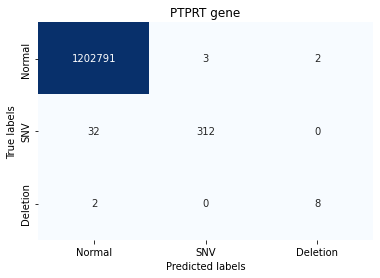

In [ ]:
# Hyperparameter

window_size = 150
stride = 50
testSchem = 'Uniform'
sampling = 'RUS' # '_' or 'RUS' (Random Undersampling)
gene = 'EGFR'

# load data test
data = np.load(datapath+gene+str(window_size)+'_'+'0'+testSchem+'.npz')
X_test = data['X_test']
Y_test = data['Y_test']

print('Window size: ', window_size)
print('Stride: ', stride)
print('Sampling: ', sampling)
if (dnn == 'BiLSTM'): print('BiLSTM: ', units, dropout)
elif (dnn == 'GRU'): print('GRU: ', layer, dropout)
else: print('CNN: ', layer, dropout)
print(gene)

model = tf.keras.models.load_model(modelpath+gene+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.h5')
start = time.time()
pred = np.argmax(model.predict(X_test), axis=-1)
end = time.time()
runTime = (end-start)
pred = pred.flatten()
Y_test = Y_test.flatten()
target_names = ['Normal', 'SNV', 'Insertion', 'Deletion', 'Delins'] #target_names depends on the type of mutation in the data.
#target_names = ['Normal', 'SNV', 'Insertion', 'Deletion']
#target_names = ['Normal', 'SNV', 'Insertion']
#target_names = ['Normal', 'SNV', 'Deletion']
#target_names = ['Normal', 'SNV']
print(classification_report(Y_test, pred, digits=4, target_names=target_names, zero_division=0))
print('Runtime: ', runTime)

cf_matrix = confusion_matrix(Y_test, pred)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='', ax = ax, cmap='Blues', cbar = False)
ax.title.set_text(gene+' gene')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

### Test on one sequence

In [ ]:
# Hyperparameter model
window_size = 150
stride = 50
testSchem = 'Uniform'
sampling = 'RUS' # '_' or 'RUS' (Random Undersampling)
mapping = 'Voss'
dnn = 'GRU'
dropout = 0
if dnn == 'CNN':
  layer = '4' 
else:
  numlayer = 2
  units = 128 #unit LSTM
  layer = str(numlayer)+str(units)

#===============================================================================
# Load sequence data
dfSeq = pd.read_csv(datapath+gene+'SeqData.csv')
# Load mutation target data
dfMut = pd.read_csv(datapath+gene+'TargetSeqData.csv')
# Load data division file
dfType = pd.read_csv(datapath+gene+'DataDivision.csv')
# Calculate the total length of the sequence
df = dfSeq['Sequence'].to_frame()
max_len = max(df.astype('str').applymap(lambda x: len(x)).max())
print('Dimensi data: ', len(df), max_len)
# Select id testing data 
cek = dfType[dfType['Dataset']==1] # testing data
id = np.array(cek['Idx'])

Dimensi data:  18202 3650


Sekuens test:
Sequence    ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
Name: 960, dtype: object
Hasil mapping sekuens: 
[3. 1. 4. ... 0. 0. 0.]
Dimensi input sekuens:  (3650,)
Hasil mapping target sekuens: 
[0. 0. 0. ... 0. 0. 0.]
Dimensi target sekuens:  (3650,)
Jumlah mutasi:  [[0.000e+00 3.649e+03]
 [1.000e+00 1.000e+00]]
Dimensi input sekuens setelah reshape:  (25, 150)
Dimensi target sekuens setelah reshape:  (25, 150)
              precision    recall  f1-score   support

      Normal     1.0000    1.0000    1.0000      3749
         SNV     1.0000    1.0000    1.0000         1
   Insertion     0.0000    0.0000    0.0000         0
    Deletion     0.0000    0.0000    0.0000         0
      Delins     0.0000    0.0000    0.0000         0

   micro avg     1.0000    1.0000    1.0000      3750
   macro avg     0.4000    0.4000    0.4000      3750
weighted avg     1.0000    1.0000    1.0000      3750

Sekuens test:
1   ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGGCTGCGCTCTGCCCG

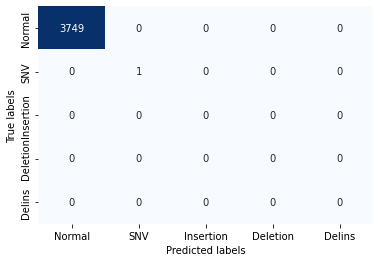

In [ ]:
# Select the sequence for which the mutation will be predicted from testing data:
# You can change this code if you have new sequence to be predict
idTest = 100
sekuens = df.iloc[id[idTest]]
print('Test sequence:')
print(sekuens)
target = dfMut.iloc[id[idTest]]
target = target['Sequence']

#===============================================================================
# Sequence Mapping
InputData=np.zeros(max_len)
for jj in range (0,len(sekuens[0])-1):
  if sekuens[0][jj]=='T':
    InputData[jj]=1
  elif sekuens[0][jj]=='C':
    InputData[jj]=2
  elif sekuens[0][jj]=='A':
    InputData[jj]=3
  elif sekuens[0][jj]=='G':
    InputData[jj]=4
  else:
    InputData[jj]=0
print('Hasil mapping sekuens: ')
print(InputData)
print('Dimensi input sekuens: ', InputData.shape)

# Target sequence mapping
TargetData=np.zeros(max_len)
for jj in range (0,len(target)-1):
  if (target[jj]=='s'):  
    TargetData[jj]=1
  elif (target[jj]=='i'):
    TargetData[jj]=2
  elif (target[jj]=='d'):
    TargetData[jj]=3
  elif (target[jj]=='e'):
    TargetData[jj]=4
  else:
    TargetData[jj]=0
print('Results of the target sequence mapping: ')
print(TargetData)
print('Sequence target dimensions: ', TargetData.shape)
(unique, counts) = np.unique(TargetData, return_counts=True)
print('Number of mutation: ', np.asarray((unique, counts)).T)

#===============================================================================
# Reshape sequence:
inputTest = InputData.flatten()
n = len(inputTest)
mod = n % window_size
if mod != 0:
  pad = np.zeros((window_size-mod))
  inputTest = np.hstack((inputTest, pad))
  targetTest = np.hstack((TargetData, pad))
inputTest = np.reshape(inputTest, (-1,window_size))
targetTest = np.reshape(targetTest, (-1,window_size))
cek = np.all(inputTest == np.zeros(window_size), axis=1)
inputTest = inputTest[cek==False]
targetTest = targetTest[cek==False]
print('Dimensi input sekuens setelah reshape: ', inputTest.shape)
print('Dimensi target sekuens setelah reshape: ', targetTest.shape)

#===============================================================================
# Load deep neural network model 
model = tf.keras.models.load_model(modelpath+gene+dnn+layer+sampling+str(dropout)+mapping+str(window_size)+str(stride)+'.h5')
# Predicting mutations in test sequences:
pred = np.argmax(model.predict(inputTest), axis=-1)
pred = pred.flatten()
targetTest = targetTest.flatten()
#target_names and labels depends on the type of mutation in the data.
target_names = ['Normal', 'SNV', 'Insertion', 'Deletion', 'Delins']
print(classification_report(targetTest, pred, digits=4, labels=[0,1,2,3,4], target_names=target_names, zero_division=0))

# Confusion Matrix
cf_matrix = confusion_matrix(targetTest, pred, labels=[0,1,2,3,4])
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='', ax = ax, cmap='Blues', cbar = False)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

#===============================================================================
# Predicted mutation index in test data:
print('Test sequence:')
ii = 1
while ii < len(sekuens[0]):
  print(ii, ' ', sekuens[0][ii-1:ii+98])
  ii += 100
if (np.count_nonzero(pred == 1)!=0):
  idMut = np.where(pred == 1)
  print('SNV mutation index: ', idMut[0]+1)
elif (np.count_nonzero(pred == 2)!=0):
  idMut = np.where(pred == 2)
  print('Insertion mutation index: ', idMut[0]+1)
elif (np.count_nonzero(pred == 3)!=0):
  idMut =np.where(pred == 3)
  print('Deletion mutation index: ', idMut[0]+1)
elif (np.count_nonzero(pred == 4)!=0):
  idMut = np.where(pred == 4)
  print('Delins mutation index: ', idMut[0]+1)

# T-Test using 5x2 CV

In [ ]:
itrCV = 4 # iteration 5x2 CV [0-4]
itrFold = 1 # fold iteration  in 2 CV [0-1]
print('CV, Fold: ', itrCV,itrFold)

CV, Fold:  4 1


### Load raw data

In [ ]:
dfSeq = pd.read_csv(datapath+gene+'SeqData.csv')
dfMut = pd.read_csv(datapath+gene+'TargetSeqData.csv')
print(dfSeq)
print(dfMut)
dfSeq.head()

       Unnamed: 0  ...                                           Sequence
0               0  ...  ATGCGACCCTCCGCGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
1               1  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGACGCTGCTGG...
2               2  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
3               3  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
4               4  ...  ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
...           ...  ...                                                ...
18197       18197  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18198       18198  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18199       18199  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18200       18200  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...
18201       18201  ...  ATGAGTTCTCTGACCAAAATCATCTGTGCCCAGCAGTGCTCCGGGC...

[18202 rows x 5 columns]
       Unnamed: 0  ...                                           Sequence
0           

,Unnamed: 0,Idx,Sample_ID,Gene_Name,Sequence
0,0,1,2717084,EGFR,ATGCGACCCTCCGCGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
1,1,2,2723457,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGACGCTGCTGG...
2,2,3,1765104,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
3,3,4,2723092,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...
4,4,5,2195069,EGFR,ATGCGACCCTCCGGGACGGCCGGGGCAGCGCTCCTGGCGCTGCTGG...


### Generate index of 5x2-fold CV: train and test set

In [ ]:
# Load data train
data = np.ones(len(dfSeq))
# Generate index 2 fold CV 5 times
for ii in range(5):
  kf = KFold(n_splits=2, shuffle=True)
  trainIdx = []
  testIdx = []
  for train, test in kf.split(data):
    trainIdx.append(train)
    testIdx.append(test)
    
  # Save data
  open_file = modelpath+gene+'CV5x2_'+str(ii)+'.pkl'
  with open(open_file, 'wb') as f:
    pickle.dump([trainIdx,testIdx], f)
  print(ii)
  print(len(train),len(test))

0
9101 9101
1
9101 9101
2
9101 9101
3
9101 9101
4
9101 9101


### Load numeric integer sequence

In [ ]:
# load the required data:
data = np.load(datapath+gene+'SeqInteger.npy')
target = np.load(datapath+gene+'SeqTarget.npy')

# Load cross validation index
open_file = modelpath+gene+'CV5x2_'+str(itrCV)+'.pkl'
with open(open_file, 'rb') as f:
  cvIdx = pickle.load(f)

# training and testing data division
if itrFold==0:
  inputTrain, inputTest = data[(cvIdx[itrFold][0])], data[(cvIdx[itrFold][1])]
  targetTrain, targetTest = target[(cvIdx[itrFold][0])], target[(cvIdx[itrFold][1])]
elif itrFold==1:
  inputTrain, inputTest = data[(cvIdx[itrFold][1])], data[(cvIdx[itrFold][0])]
  targetTrain, targetTest = target[(cvIdx[itrFold][1])], target[(cvIdx[itrFold][0])]
print('Data train:')
print(inputTrain.shape)
print(targetTrain.shape)
print('Data test:')
print(inputTest.shape)
print(targetTest.shape)
print('CV, Fold: ', itrCV,itrFold)

Data train:
(9101, 3650)
(9101, 3650)
Data test:
(9101, 3650)
(9101, 3650)
CV, Fold:  2 1


### Reshape sequence (do this for each iteration in 5x2CV)

#### Data train

In [ ]:
InputData = inputTrain.flatten()
TargetData = targetTrain.flatten()

# Reshape sequence according to window size and stride
if stride==0:
  # Reshape sequence without overlap
  # Checks whether the length of the sequence to be reshaped matches the window_size
  m = len(InputData)
  mod = m % window_size
  if mod != 0:
    pad = np.zeros((window_size-mod))
    InputData = np.hstack((InputData, pad))
    TargetData = np.hstack((TargetData, pad))

  # Reshape data according to window size
  X_train = np.reshape(InputData, (-1,window_size))
  Y_train = np.reshape(TargetData, (-1,window_size))

else:
  # Reshape sequence with overlap
  shape = (InputData.shape[0] - window_size + 1, window_size) + InputData.shape[1:]
  strides = (InputData.strides[0],) + InputData.strides
  X_train = np.lib.stride_tricks.as_strided(InputData, shape=shape, strides=strides)[::stride,:]
  Y_train = np.lib.stride_tricks.as_strided(TargetData, shape=shape, strides=strides)[::stride,:]

# Remove empty sub sequence
cek = np.all(X_train == np.zeros(window_size), axis=1)
X_train = X_train[cek==False]
Y_train = Y_train[cek==False]

np.savez(datapath+'DataTrain5x2CV_'+str(window_size)+'_'+str(stride)+'_'+str(itrCV)+'_'+str(itrFold)+'.npz',
          X_train=X_train, Y_train=Y_train)
print(X_train.shape)
print(Y_train.shape)
print('CV, Fold: ', itrCV,itrFold)

(639904, 150)
(639904, 150)
CV, Fold:  2 1


Random Under Sampling (optional)

In [ ]:
# Create temporary target data
Y = np.zeros(len(Y_train))
for ii in range(len(Y_train)):
  if ((np.max(Y_train[ii]))!=0):
    Y[ii] = 1
print('Number of sub sequences before resampling: ', Counter(Y))
# Indexing the data before resampling
counter = range(0,len(Y))
counter = (np.array(counter)).reshape(-1, 1)
# resampling process
rus = RandomUnderSampler(random_state=0)
index, Y_resampled = rus.fit_resample(counter,Y)
index = index.reshape(1, -1)
print('Number of sub sequences after resampling: ', Counter(Y_resampled))

# save the resampled sub-sequence
X_train = X_train[index]
Y_train = Y_train[index]
X_train = X_train[0]
Y_train = Y_train[0]
np.savez(datapath+'DataTrain5x2CV_'+str(window_size)+'_'+str(stride)+'_'+str(itrCV)+'_'+str(itrFold)+'.npz',
          X_train=X_train, Y_train=Y_train)
print(X_train.shape)
print(Y_train.shape)
print('CV, Fold: ', itrCV,itrFold)

Jumlah baris data sebelum resampling:  Counter({0.0: 610976, 1.0: 28928})
Jumlah baris data setelah resampling:  Counter({0.0: 28928, 1.0: 28928})
(57856, 150)
(57856, 150)
CV, Fold:  2 1


#### Data test

In [ ]:
InputData = inputTest.flatten()
TargetData = targetTest.flatten()

m = len(InputData)
mod = m % window_size
if mod != 0:
  pad = np.zeros((window_size-mod))
  InputData = np.hstack((InputData, pad))
  TargetData = np.hstack((TargetData, pad))

# Reshape data according to window size
X_test = np.reshape(InputData, (-1,window_size))
Y_test = np.reshape(TargetData, (-1,window_size))

# Remove empty subsequence
cek = np.all(X_test == np.zeros(window_size), axis=1)
X_test = X_test[cek==False]
Y_test = Y_test[cek==False]

np.savez(datapath+'DataTest5x2CV_'+str(window_size)+'_'+str(stride)+'_'+str(itrCV)+'_'+str(itrFold)+'.npz',
          X_test=X_test, Y_test=Y_test)
print(X_test.shape)
print(Y_test.shape)
print('CV, Fold: ', itrCV,itrFold)

(213171, 150)
(213171, 150)
CV, Fold:  2 1


### Training and testing process (do this for each iteration in 5x2 CV)

In [ ]:
# Load training and testing data
data = np.load(datapath+'DataTrain5x2CV_'+str(window_size)+'_'+str(stride)+'_'+str(itrCV)+'_'+str(itrFold)+'.npz')
X_train = data['X_train']
Y_train = data['Y_train']
data = np.load(datapath+'DataTest5x2CV_'+str(window_size)+'_'+str(stride)+'_'+str(itrCV)+'_'+str(itrFold)+'.npz')
X_test = data['X_test']
Y_test = data['Y_test']
numClasses = len(np.unique(np.concatenate((Y_train, Y_test))))
print(numClasses)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# Converts the target training data representation to one hot encoding
Y_train = [tf.keras.utils.to_categorical(i, num_classes=numClasses) for i in Y_train]
Y_train = np.array(Y_train)

embedding_dim = embedding_matrix.shape[1]
vocab_size = 4+1 # number of nucleotide = 4
print('CV, Fold: ', itrCV,itrFold)

5
(57892, 150) (57892, 150)
(213074, 150) (213074, 150)
CV, Fold:  4 1


In [ ]:
print('Window size: ', window_size)
print('Stride: ', stride)
print('Sampling: ', sampling)
if (dnn == 'BiLSTM'): print('BiLSTM: ', layer, dropout)
elif (dnn == 'GRU'): print('GRU: ', layer, dropout)
else: print('CNN: ', layer, dropout)

EPOCHS = 20
BATCH_SIZE = 24
itr1 = 0
itr2 = 5
for ii in range(itr1,itr2):
  print(ii)
  print('CV, Fold: ', itrCV,itrFold)
  # Create model
  if ii == 0:
    model = modelDNN()
    trainLoss = []
    valLoss = []
  else:
    model = tf.keras.models.load_model(modelpath+dnn+'5x2CV_'+str(window_size)+'_'+str(stride)+'_'+str(itrCV)+'_'+str(itrFold)+'.h5')
  
  # Train model
  train_history = model.fit(X_train, Y_train, validation_split=0.05, shuffle=True,
                          epochs=EPOCHS, batch_size=BATCH_SIZE)
  model.save(modelpath+dnn+'5x2CV_'+str(window_size)+'_'+str(stride)+'_'+str(itrCV)+'_'+str(itrFold)+'.h5')
  
print('Train Loss: ', train_history.history['loss'][EPOCHS-1])
print('Validation Loss: ', train_history.history['val_loss'][EPOCHS-1])

# Evaluation on test data
pred = np.argmax(model.predict(X_test), axis=-1)
pred = pred.flatten()
Y_test = Y_test.flatten()
target_names = ['Normal', 'SNV', 'Insertion', 'Deletion', 'Delins']
print(classification_report(Y_test, pred, digits=4, target_names=target_names, zero_division=0))
print(gene)

# Save test F1-Score
f1 = f1_score(Y_test, pred, average='macro')
if itrCV==0 and itrFold==0:
  f1All = []
else:
  temp = np.load(modelpath+'Score_'+dnn+'.npz')
  f1All = temp['f1All']
f1All = np.append(f1All, f1)
np.savez(modelpath+'Score_'+dnn+'.npz', f1All=f1All)
print('Macro F1-Score: ', f1)

Window size:  150
Stride:  50
Sampling:  RUS
BiLSTM:  2_256 0.2
0
CV, Fold:  4 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 4)            20        
                                                                 
 bidirectional (Bidirectiona  (None, 150, 512)         534528    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 150, 512)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 512)         1574912   
 nal)                                                            
                                              

### Calculate T-Test and p-value

In [ ]:
from scipy import stats
temp = np.load(modelpath+'Score_BiLSTM.npz')
f1BiLSTM = temp['f1All']
temp = np.load(modelpath+'Score_GRU.npz')
f1BiGRU = temp['f1All']
t,p = stats.ttest_ind(f1BiLSTM, f1BiGRU)
print('p-value: ', p)
print('t-statistic: ', t)
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')

p-value:  0.5045546202989559
t-statistic:  -0.6809743295337836
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.
